# Little NB for checking muscle extraction results

Just want to make sure I'm getting somewhat reasonable results

In [1]:
import muscle_model as mm
import os
import h5py
import cPickle

import numpy as np
import matplotlib.pyplot as plt

from scipy.ndimage import binary_closing, binary_dilation

## Load data

In [2]:
# path to fly we want to analyze
root_path = '/media/sam/SamData/FlyDB'
fly_num = 35
# side = 'right'

folder = 'Fly%04d' %(fly_num)
# subfolder = 'code_result'

In [3]:
# load my dict containing the different data types
data_path = os.path.join(root_path, folder, 'combined_dict.hdf5')
data_dict = dict()

with h5py.File(data_path, 'r') as h5f:
    for key in h5f.keys():
        data_dict[key] = h5f[key][:]

## Copying a useful function over -- should probably just import this 

In [4]:
def idx_by_thresh(signal,thresh = 0.1):
    import numpy as np
    idxs = np.squeeze(np.argwhere((signal > thresh).astype(np.int)))
    try:
        split_idxs = np.squeeze(np.argwhere(np.diff(idxs) > 1))
    except IndexError:
        #print 'IndexError'
        return None
    #split_idxs = [split_idxs]
    if split_idxs.ndim == 0:
        split_idxs = np.array([split_idxs])
    #print split_idxs
    try:
        idx_list = np.split(idxs,split_idxs)
    except ValueError:
        #print 'value error'
        np.split(idxs,split_idxs)
        return None
    idx_list = [x[1:] for x in idx_list]
    idx_list = [x for x in idx_list if len(x)>0]
    return idx_list

## Check wing kinematics

In [5]:
# make a dumb little function for comparison
def my_plot_dict_var(data_dict, key_y, key_x='time', ax=None):
    # read out data
    var_y = np.squeeze(data_dict[key_y])
    var_x = np.squeeze(data_dict[key_x])
    
    # make plots
    if not ax:
        fig, ax = plt.subplots(figsize=(8,5))
    
    ax.plot(var_x, var_y, label=key_y)
    ax.set_title('%s vs %s' % (key_y, key_x))
    ax.set_xlabel(key_x.replace('_', ' '))
    ax.set_ylabel(key_y.replace('_', ' '))
    
    plt.tight_layout()

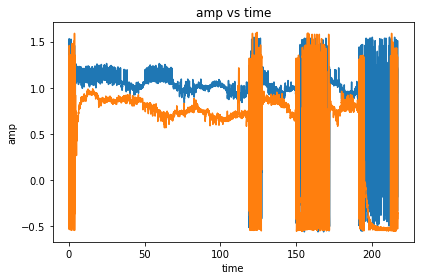

In [6]:
# wing amplitude first
fig, ax = plt.subplots()
sides = ['left', 'right']
for side in sides:
    my_plot_dict_var(data_dict, '%s_amp' % side, ax=ax)
data_dict
ax.set_title('amp vs time') ;
ax.set_ylabel('amp') ;

# # TEMP - test saving
# fig_save_path = '/home/sam/Desktop'
# fig.savefig(os.path.join(fig_save_path, 'test0.svg'))

# fig.set_size_inches(30, fig.get_figheight(), forward=True)
# fig.savefig(os.path.join(fig_save_path, 'test1.svg'), bbox_inches='tight')


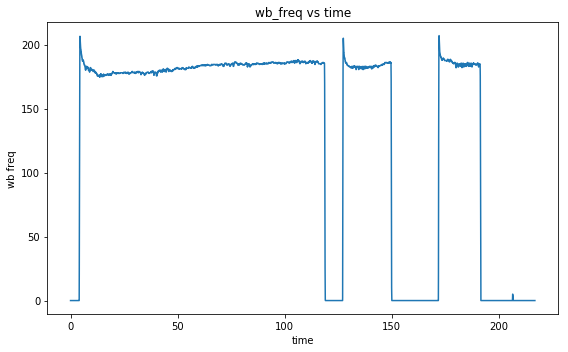

In [7]:
# wbf
my_plot_dict_var(data_dict, 'wb_freq')

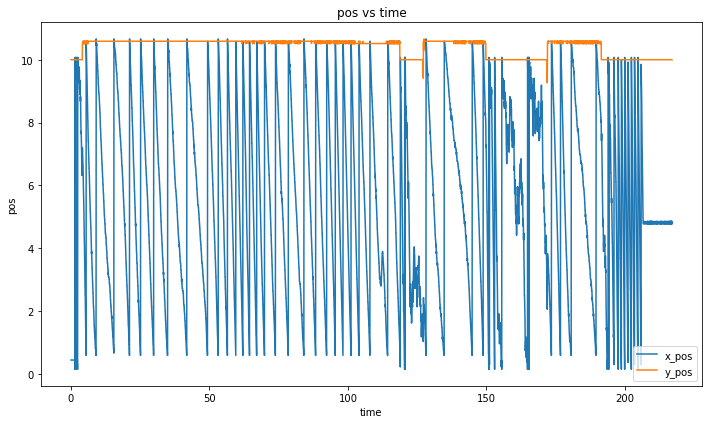

In [8]:
# daq fieldsdata_path,
daq_fields = ['x_pos', 'y_pos']
fig, ax = plt.subplots(figsize=(10,6))
for fld in daq_fields:
    my_plot_dict_var(data_dict, fld, ax=ax)
    
ax.set_title('pos vs time') ;
ax.set_ylabel('pos') ;
ax.legend()

## Use kinematic data to identify any bad data points

In [9]:
# # use jumps in wingbeat frequency as first pass
# t = data_dict['time']
# wb_freq = data_dict['wb_freq']

# fig, ax = plt.subplots()
# ax.plot(t[1:], np.diff(wb_freq))

# print(ignore_idx.shape)
# ignore_idx = (np.abs(np.diff(wb_freq)) > 1.0)
# ignore_idx = np.concatenate((np.array([0], dtype='bool'), ignore_idx))
# print(ignore_idx.shape)

# # make sure we don't leave holes in ignore_idx
# ignore_idx = binary_closing(ignore_idx, structure=np.ones((15,)))
# ignore_idx = binary_dilation(ignore_idx, structure=np.ones((8,)))

# # plot cleaned up wbf
# fig, ax = plt.subplots()
# ax.plot(t, wb_freq)
# ax.plot(t[~ignore_idx], wb_freq[~ignore_idx])

# ignore_ind = np.argwhere(ignore_idx)
# # print(ignore_ind)
# # print(np.argmax(wb_freq))

In [10]:
# # add ignore_idx to data_dict
# data_dict['ignore_idx'] = ignore_idx

## Look at muscle signals

In [11]:
def plot_muscle_grid(model_fits, side=None, ax_list=None):
    # generate new figure if we need to
    try:
        ax_list_length = len(ax_list)
    except TypeError:
        fig, ax_list = plt.subplots(3,4, figsize=(12,6))
        
    # list of muscles that we want to look at 
    muscle_keys = ['b1', 'b2', 'b3', 'i1', 'i2', 'iii1', 'iii24', 'iii3', 'hg1', 'hg2', 'hg3', 'hg4']
    
    # read from data dict
    time = np.squeeze(model_fits['time'])
    plot_keys = [key for key in model_fits.keys() if any(mkey in key for mkey in muscle_keys)]
    
    # only retain one side, if given as input
    if side:
        plot_keys = [key for key in plot_keys if side in key]
    
    # sort?
    plot_keys.sort()
    # loop over keys and plot
    for (ith, key) in enumerate(plot_keys):
        # read out x and y data 
        x_dat = time.copy()
        y_dat = model_fits[key].copy()
        
        # check if we should ignore some values though
        if 'ignore_idx' in data_dict.keys():
            x_dat[data_dict['ignore_idx']] = np.nan
            y_dat[data_dict['ignore_idx']] = np.nan
#             x_dat = x_dat[~data_dict['ignore_idx']]
#             y_dat = y_dat[~data_dict['ignore_idx']]
            
        # plot to axis
        plot_idx = np.unravel_index(ith, ax_list.shape)
        ax_list[plot_idx].plot(x_dat, y_dat, label=key)
        
        # set title to be muscle name
        ax_list[plot_idx].set_title(key.replace('_', ' '))
    
    # ensure a good subplot layout
    plt.tight_layout()
    
    # return axis list so we can double up on plots
    return ax_list

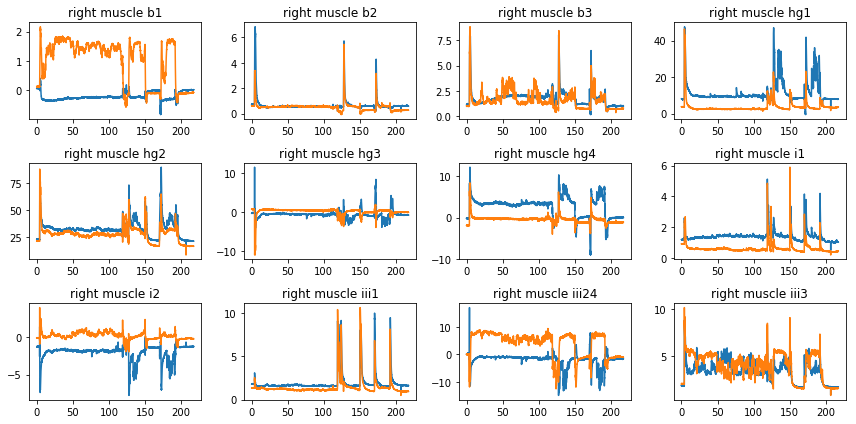

In [12]:
ax_list = None
ax_list = plot_muscle_grid(data_dict, side='left')
ax_list = plot_muscle_grid(data_dict, side='right', ax_list=ax_list)

In [28]:
# TEMP -- look at live viewer data
live_viewer_path = os.path.join(root_path, folder, 'converted.hdf5')
live_viewer_dict = dict()
group_key = 'live_viewer_left'

with h5py.File(live_viewer_path, 'r') as f:
    print(f.keys())
#     for key in f[group_key].keys():
#         print(key)
#         live_viewer_dict[key] = f[group_key][key]

# print(live_viewer_dict['b1'])
# live_viewer_dict['time'] = np.linspace(0, data_dict['time'][-1], live_viewer_dict['b1'].size)

[u'daq_channels', u'daq_ros_tstamps', u'daq_time', u'daq_value', u'exp_block', u'exp_state', u'flystate_langles', u'flystate_lgrandients', u'flystate_lintensity', u'flystate_rangles', u'flystate_rgradients', u'flystate_rintensity', u'flystate_seq', u'flystate_tstamps', u'ledpanels_panels_arg1', u'ledpanels_panels_arg2', u'ledpanels_panels_arg3', u'ledpanels_panels_arg4', u'ledpanels_panels_arg5', u'ledpanels_panels_arg6', u'ledpanels_panels_command', u'ledpanels_ros_tstamps', u'unmixer_left', u'unmixer_right']


In [29]:
# do we have exp_state or exp_block in combined data_dict?
for key in sorted(data_dict.keys()):
    print(key)

exp_block
exp_state
left_amp
left_muscle_b1
left_muscle_b2
left_muscle_b3
left_muscle_bkg
left_muscle_hg1
left_muscle_hg2
left_muscle_hg3
left_muscle_hg4
left_muscle_i1
left_muscle_iii1
left_muscle_iii24
left_muscle_iii3
left_muscle_nm
left_muscle_pr
right_amp
right_muscle_b1
right_muscle_b2
right_muscle_b3
right_muscle_bkg
right_muscle_hg1
right_muscle_hg2
right_muscle_hg3
right_muscle_hg4
right_muscle_i1
right_muscle_iii1
right_muscle_iii24
right_muscle_iii3
right_muscle_nm
right_muscle_pr
time
wb_freq
x_pos
y_pos


In [30]:
data_dict['x_pos']

array([0.44117647, 0.44117647, 0.44117647, ..., 4.77941176, 4.77941176,
       4.77941176])